Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [10]:
from sklearn import datasets
digits = datasets.load_digits()
X = digits.data
y = digits.target
print (X.shape)
print (y.shape)

(1797, 64)
(1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

<Figure size 432x288 with 0 Axes>

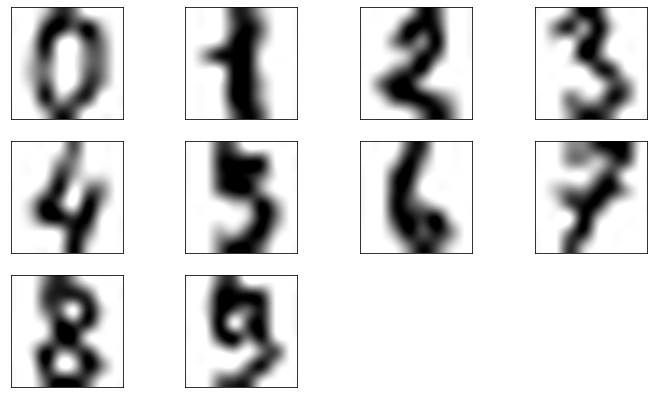

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray()
plt.figure(figsize=(12, 7))
for i in range(10):
    plt.subplot(3, 4, i + 1 , xticks=[], yticks=[])
    plt.imshow(X[i,:].reshape([8,8]), interpolation = 'spline36' , cmap='binary' );
plt.show()  

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [4]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
clf1 = AgglomerativeClustering(n_clusters=10)
clf2 = KMeans(n_clusters=10, n_init=100 )

In [13]:
p1,p2  = clf1.fit_predict(X) , clf2.fit_predict(X)
print(p1,p2)
print(p1.shape,p2.shape)

[7 9 4 ... 4 1 4] [1 6 6 ... 6 9 9]
(1797,) (1797,)


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

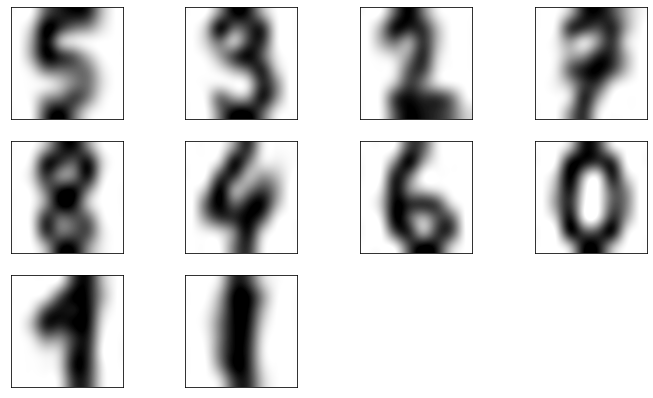

In [14]:
plt.figure(figsize=(12, 7))
for i in range(10):
    plt.subplot(3, 4, i + 1, xticks=[], yticks=[])
    plt.imshow(np.mean(X[(p1 == i)],axis=0).reshape([8,8]) , interpolation = 'spline36' ,cmap='binary' );

plt.show()

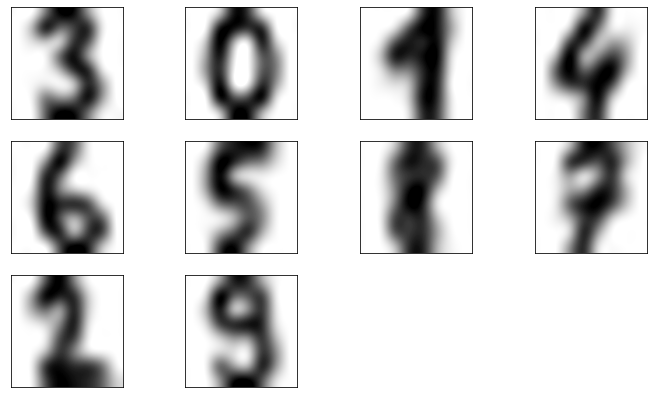

In [15]:
plt.figure(figsize=(12, 7))
for i in range(10):
    plt.subplot(3, 4, i + 1,  xticks=[], yticks=[])
    plt.imshow(np.mean(X[(p2 == i)],axis=0).reshape([8,8]), interpolation = 'spline36' , cmap='binary' );
plt.xticks()  
plt.yticks()  
plt.show()  

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [16]:
from sklearn.metrics import silhouette_score
K = range(2,21)
S1 = []
S2 = []
for i in K:
    clf1 = AgglomerativeClustering(n_clusters=i)
    clf2 = KMeans(n_clusters=i, n_init=100 )
    p1 = clf1.fit_predict(X)
    p2 = clf2.fit_predict(X)
    S1.append(silhouette_score(X,p1))
    S2.append(silhouette_score(X,p2))    

Mасимальное значение силуэта для  AgglomerativeClustering 0.18061975703867697  и количесво кластеров 9
Mасимальное значение силуэта для  KMeans 0.18949020494314225  и количесво кластеров 9


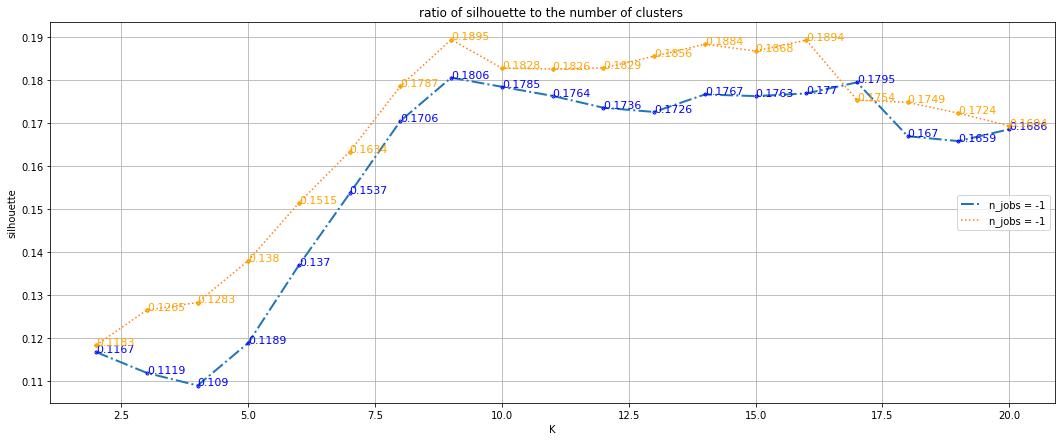

In [17]:
plt.figure(figsize=(18, 7))
plt.plot(K, S1, label='n_jobs = -1', linewidth=2, linestyle = '-.') # drawstyle = 'steps-post'
plt.plot(K, S2, label='n_jobs = -1' , linestyle = ':')
plt.title('ratio of silhouette to the number of clusters ')
plt.xlabel('K') 
plt.ylabel('silhouette')
plt.grid(True)
plt.legend(loc='center right')
for i,j,k in zip(K,S1,S2):
    plt.plot(i,j, marker = 'o',
        markersize = 1,
        color = 'b',
        markeredgewidth = 3)
    plt.plot(i,k, marker = 'X',
        markersize = 1,
        color = 'orange',
        markeredgewidth = 3)
    plt.text(i,j,str(round(j,4)),color = 'b', size = 11)
    plt.plot(i,k)
    plt.text(i,k,str(round(k,4)),color = 'orange' , size = 11)
    if (j == np.max(S1)):
        print('Mасимальное значение силуэта для  AgglomerativeClustering {}  и количесво кластеров {}'.format(j,i))
    if (k == np.max(S2)):
        print('Mасимальное значение силуэта для  KMeans {}  и количесво кластеров {}'.format(k,i))

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [18]:
from sklearn.metrics import v_measure_score
K = range(2,21)
S11 = []
S22 = []
for i in K:
    clf1 = AgglomerativeClustering(n_clusters=i)
    clf2 = KMeans(n_clusters=i, n_init=100 )
    p1 = clf1.fit_predict(X)
    p2 = clf2.fit_predict(X)
    S11.append(v_measure_score(y,p1))
    S22.append(v_measure_score(y,p2))   

Mасимальное значение V меры для  AgglomerativeClustering 0.86854875186737  и количесво кластеров 12
Mасимальное значение V меры для  KMeans 0.7892202390358636  и количесво кластеров 17


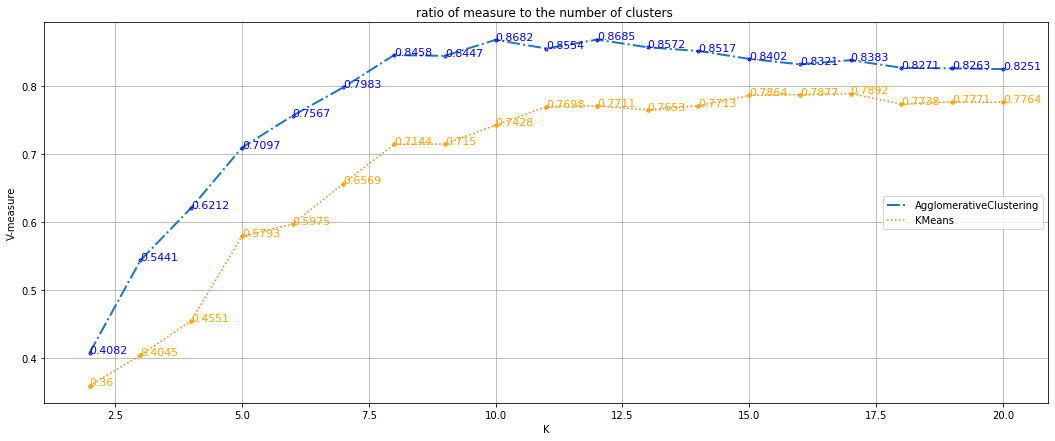

In [19]:
plt.figure(figsize=(18, 7))
plt.plot(K, S11, label='AgglomerativeClustering', linewidth=2, linestyle = '-.') # drawstyle = 'steps-post'
plt.plot(K, S22, label='KMeans' , linestyle = ':')
plt.title('ratio of measure to the number of clusters ')
plt.xlabel('K') 
plt.ylabel('V-measure')
plt.grid(True)
plt.legend(loc='center right')
for i,j,k in zip(K,S11,S22):
    plt.plot(i,j, marker = 'o',
        markersize = 1,
        color = 'b',
        markeredgewidth = 3)
    plt.plot(i,k, marker = 'X',
        markersize = 1,
        color = 'orange',
        markeredgewidth = 3)
    plt.text(i,j,str(round(j,4)),color = 'b', size = 11)
    plt.plot(i,k)
    plt.text(i,k,str(round(k,4)),color = 'orange' , size = 11)
    if (j == np.max(S11)):
        print('Mасимальное значение V меры для  AgglomerativeClustering {}  и количесво кластеров {}'.format(j,i))
    if (k == np.max(S22)):
        print('Mасимальное значение V меры для  KMeans {}  и количесво кластеров {}'.format(k,i))

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [20]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
S_1 , S_2 ,S_11 , S_22 = [] , [] ,[] ,[]
P = np.array([2,5,10,20])
for i in P:
    svd = TruncatedSVD(n_components = i)
    clf1 = AgglomerativeClustering(n_clusters=10)
    clf2 = KMeans(n_clusters=10, n_init=100 )
    S_1.append(silhouette_score(X,clf1.fit_predict(svd.fit_transform(X))))
    S_2.append(silhouette_score(X,clf2.fit_predict(svd.fit_transform(X))))
    S_11.append(v_measure_score(y,clf1.fit_predict(svd.fit_transform(X))))
    S_22.append(v_measure_score(y,clf2.fit_predict(svd.fit_transform(X))))

Mасимальное значение V меры для  AgglomerativeClustering 0.8259753348813222  и количесво кластеров 10
Mасимальное значение V меры для  KMeans 0.7422729794392336  и количесво кластеров 20


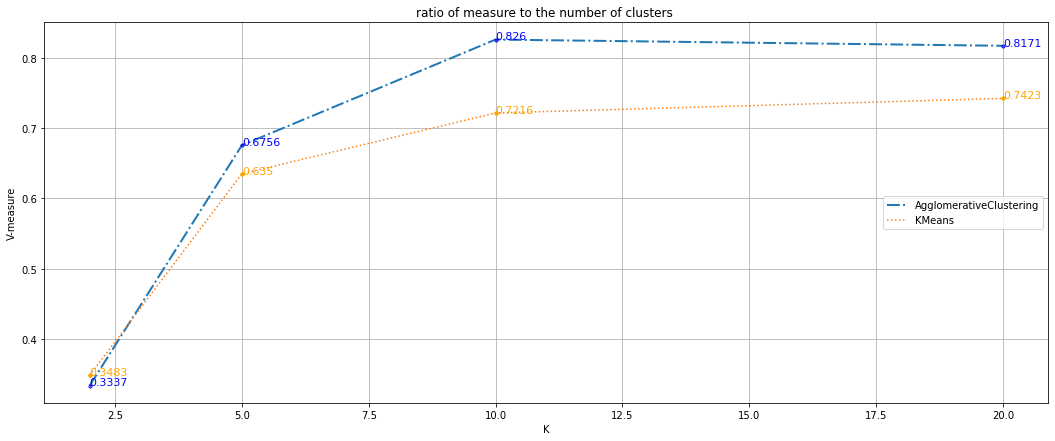

In [21]:
plt.figure(figsize=(18, 7))
plt.plot(P, S_11, label='AgglomerativeClustering', linewidth=2, linestyle = '-.') # drawstyle = 'steps-post'
plt.plot(P, S_22, label='KMeans' , linestyle = ':')
plt.title('ratio of measure to the number of clusters ')
plt.xlabel('K') 
plt.ylabel('V-measure')
plt.grid(True)
plt.legend(loc='center right')
for i,j,k in zip(P,S_11,S_22):
    plt.plot(i,j, marker = 'o',
        markersize = 1,
        color = 'b',
        markeredgewidth = 3)
    plt.plot(i,k, marker = 'X',
        markersize = 1,
        color = 'orange',
        markeredgewidth = 3)
    plt.text(i,j,str(round(j,4)),color = 'b', size = 11)
    plt.plot(i,k)
    plt.text(i,k,str(round(k,4)),color = 'orange' , size = 11)
    if (j == np.max(S_11)):
        print('Mасимальное значение V меры для  AgglomerativeClustering {}  и количесво кластеров {}'.format(j,i))
    if (k == np.max(S_22)):
        print('Mасимальное значение V меры для  KMeans {}  и количесво кластеров {}'.format(k,i))

Mасимальное значение силуэта для  AgglomerativeClustering 0.1765881132796084  и количесво кластеров 10
Mасимальное значение силуэта для  KMeans 0.1823862502695893  и количесво кластеров 20


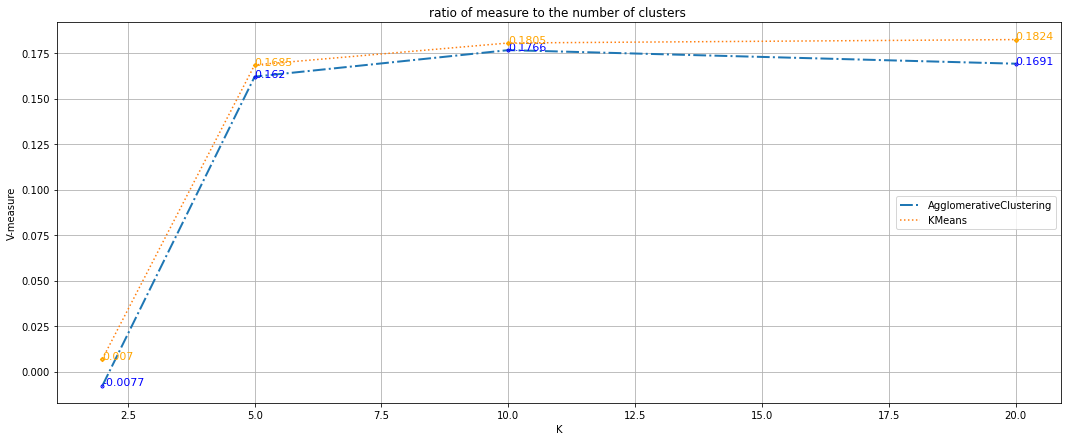

In [22]:
plt.figure(figsize=(18, 7))
plt.plot(P, S_1, label='AgglomerativeClustering', linewidth=2, linestyle = '-.') # drawstyle = 'steps-post'
plt.plot(P, S_2, label='KMeans' , linestyle = ':')
plt.title('ratio of measure to the number of clusters ')
plt.xlabel('K') 
plt.ylabel('V-measure')
plt.grid(True)
plt.legend(loc='center right')
for i,j,k in zip(P,S_1,S_2):
    plt.plot(i,j, marker = 'o',
        markersize = 1,
        color = 'b',
        markeredgewidth = 3)
    plt.plot(i,k, marker = 'X',
        markersize = 1,
        color = 'orange',
        markeredgewidth = 3)
    plt.text(i,j,str(round(j,4)),color = 'b', size = 11)
    plt.plot(i,k)
    plt.text(i,k,str(round(k,4)),color = 'orange' , size = 11)
    if (j == np.max(S_1)):
        print('Mасимальное значение силуэта для  AgglomerativeClustering {}  и количесво кластеров {}'.format(j,i))
    if (k == np.max(S_2)):
        print('Mасимальное значение силуэта для  KMeans {}  и количесво кластеров {}'.format(k,i))

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [11]:
from sklearn.manifold import TSNE
svdtnse = TSNE()
SNE = svdtnse.fit_transform(X)

<function matplotlib.pyplot.show(close=None, block=None)>

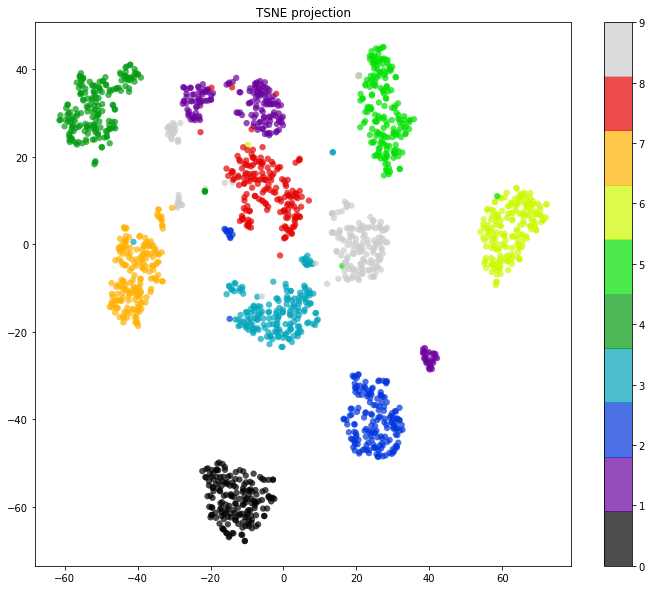

In [24]:
plt.figure(figsize=(12,10))
plt.scatter(SNE[:, 0], SNE[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('TSNE projection')
plt.show

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [25]:
SNE = SNE.reshape(-1,2)
clf1 = KMeans(n_clusters=10, n_init=100 )
clf2 = AgglomerativeClustering(n_clusters=10)
print ( silhouette_score(X,clf1.fit_predict(SNE)) )
print ( v_measure_score(y,clf1.fit_predict(SNE)) )
print ( silhouette_score(X,clf2.fit_predict(SNE)) )
print ( v_measure_score(y,clf2.fit_predict(SNE)) )

0.16442275824787037
0.9113662349403062
0.16427420678001095
0.9105050964841241


##           𝑉-мера получилсть больше чем на исходных данных, в то время как силуэт мельнше.

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

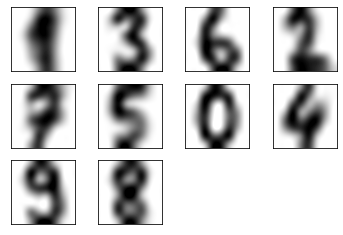

In [26]:
p1 = clf1.fit_predict(SNE)
for i in range(10):
    plt.subplot(3, 4, i + 1, xticks=[], yticks=[])
    plt.imshow(np.mean(X[(p1 == i)],axis=0).reshape([8,8]) , interpolation = 'spline36' ,cmap='binary' );

plt.show()

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

Как видно из графиков Иерархическая кластеризация дает значения силуэта и V- меры немного больше чем K средних.Но Когда я попробовал запустить Иерахическую кластеризацию в последнем задании мне не хватило памяти.Иерархическая кластеризация потребляем намого больше ресурсов и работает медленнее чем K средних . Настройка колличесва инизиализаций K средних повышает качество разбиения, так же снижение признакого простарнсва повышает значения силуэта и V-меры следовательно данные разбиваются лучше.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [1]:
from keras.datasets import mnist

In [12]:
(X, y), (d1, d2) = mnist.load_data()

In [13]:
X_nev = X.reshape(-1,784)

In [14]:
X_nev.shape

(60000, 784)

<Figure size 432x288 with 0 Axes>

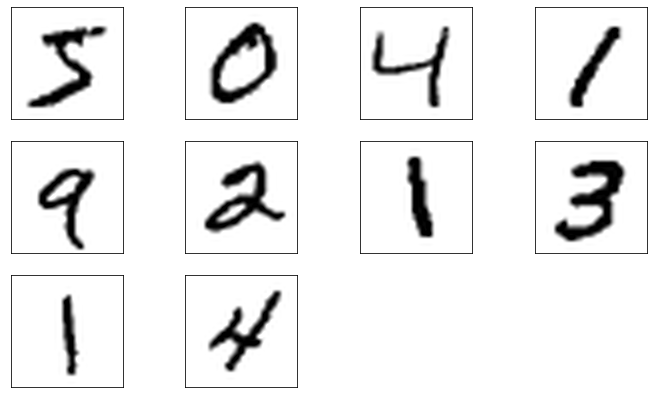

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.gray()
plt.figure(figsize=(12, 7))
for i in range(10):
    plt.subplot(3, 4, i + 1 , xticks=[], yticks=[])
    plt.imshow(X_nev[i,:].reshape([28,28]), interpolation = 'spline36' , cmap='binary' );
plt.show()  

In [16]:
svdtnse = TSNE()
X_sne= svdtnse.fit_transform(X_nev)

In [17]:
X_sne

array([[-21.722784 , -24.277027 ],
       [-44.91593  ,  -7.2256513],
       [ 35.271984 , -27.765379 ],
       ...,
       [-18.137516 , -25.01119  ],
       [ -1.3870538, -48.008827 ],
       [ -4.447787 ,  19.673395 ]], dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

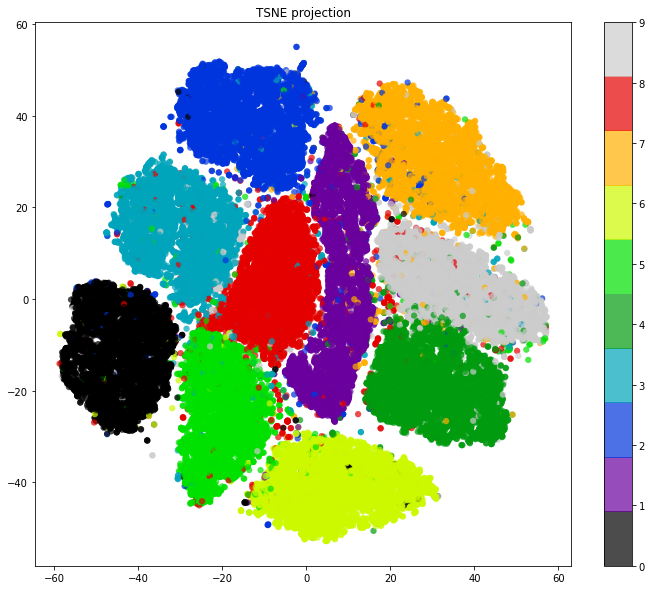

In [19]:
plt.figure(figsize=(12,10))
plt.scatter(X_sne[:, 0], X_sne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('TSNE projection')
plt.show

In [22]:
from sklearn.metrics import v_measure_score
from sklearn.metrics import silhouette_score
clf1 = KMeans(n_clusters=10, n_init = 300 )

p = clf1.fit_predict(X_sne)


0.3993898
0.7995384983558


In [29]:
print ('silhouette_score :{}'.format( silhouette_score(X_sne,p) ) )
print ('v_measure_score :{}'.format(v_measure_score(y,p))  )

silhouette_score :0.3993898034095764
v_measure_score :0.7995384983558
